# Template for HW4
Use this file as a template. In your submission, save any computation results and outputs and submit the file, so we can see it when we grade.

You'll be using the tutorial at https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae as a starting point.
Then you'll modify it so that it uses the dataset "sentence-transformers/all-nli" instead. You'll need to really understand how the code works to do this: look up the documentation for the individual functions. Read about the dataset and find out its structure.

In [12]:

!pip install --quiet transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 24.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [13]:
#load modernbert (base) and your dataset here. Follow the tutorial (with any necessary modifications) at: https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict, IterableDatasetDict
from datasets.iterable_dataset import IterableDataset
import numpy as np

from transformers import Trainer, TrainingArguments

# Dataset id from huggingface.co/dataset
# dataset_id = "argilla/synthetic-domain-text-classification"
dataset_id = "sentence-transformers/all-nli"

# Load raw dataset
# train_dataset = load_dataset(dataset_id, split='train')
train_dataset = load_dataset(dataset_id, 'pair-class', split='train[:3%]')
#divide train set into fraction of the size, so more computationally feasible


split_dataset = train_dataset.train_test_split(test_size=0.1)
# print(split_dataset['train'][5:7])
print(split_dataset)

# create a new column in split_dataset which concatenates the "premise" and "hypothesis" columns
split_dataset = split_dataset.map(lambda x: {"text": x["premise"] + " <s> " + x["hypothesis"]}, remove_columns=["premise", "hypothesis"])
# print(split_dataset['train'][5:7])
# print(split_dataset)

from transformers import AutoTokenizer

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Tokenize helper function
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding="max_length", return_tensors="pt", max_length=500)#tokenizer.model_max_length)


# Tokenize dataset
if "label" in split_dataset["train"].features.keys():
    split_dataset =  split_dataset.rename_column("label", "labels") # to match Trainer
tokenized_dataset = split_dataset.map(tokenize, batched=True, remove_columns=["text"])

from transformers import AutoModelForSequenceClassification

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Prepare model labels - useful for inference
labels = tokenized_dataset["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Download the model from huggingface.co/models
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev-00000-of-00001.parquet:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 25435
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2827
    })
})


Map:   0%|          | 0/25435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/25435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [21]:
# train your model here, using fine-tuning. Print out training data and save it as part of this notebook file. Again follow the tutorial (with any necessary modifications) at: https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae

from transformers import Trainer, TrainingArguments

# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-domain-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=2,
    bf16=True, # bfloat16 training
    optim="adamw_torch_fused", # improved optimizer
    # logging & evaluation strategies
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"] #note that we're using the test set as the validation set here---normally a no-no!
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
W0425 17:36:09.006000 3601 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss,Validation Loss
500,0.991300,0.780043
1000,0.735400,0.603165
1500,0.694000,0.639623
2000,0.665200,0.561867
2500,0.692200,0.592817
3000,0.665100,0.551575
3500,0.626500,0.526408
4000,0.594000,0.681734
4500,0.611800,0.565439
5000,0.589500,0.530066


TrainOutput(global_step=12718, training_loss=0.5173492497628469, metrics={'train_runtime': 2764.8836, 'train_samples_per_second': 18.399, 'train_steps_per_second': 4.6, 'total_flos': 1.692819511767e+16, 'train_loss': 0.5173492497628469, 'epoch': 2.0})

In [22]:
predictions = trainer.predict(tokenized_dataset["test"])

In [23]:
import numpy as np


# test your trained model on the test set here. Report statistics and save the test data as part of this notebook file.
predictions = trainer.predict(tokenized_dataset["test"])

# Process the prediction results (predictions, label_ids, metrics)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_label = id2label[str(predicted_labels[0])]


example_data = [split_dataset['train'][0]]
print("Example Input:", example_data[0]['text'])
print(f"Predicted Label: {predicted_label}")
print(f"Actual Label: {id2label[str(example_data[0]['labels'])]}")



Example Input: And male and female duo perform on stage. <s> a man and woman performing on stage.
Predicted Label: neutral
Actual Label: neutral


In [25]:
import numpy as np
np.unique(predictions.label_ids, return_counts=True)


(array([0, 1, 2]), array([981, 884, 962]))

In [24]:
from sklearn.metrics import classification_report, f1_score

true_labels = predictions.label_ids
pred_labels = predictions.predictions.argmax(axis=1)

# Binary correct = 1, incorrect = 0
binary_true = [1] * len(true_labels)
binary_pred = [1 if p == t else 0 for p, t in zip(pred_labels, true_labels)]

print("F1 Score (binary correct/incorrect):", f1_score(binary_true, binary_pred))
print(classification_report(binary_true, binary_pred, target_names=["Incorrect", "Correct"]))


F1 Score (binary correct/incorrect): 0.9101773323053199
              precision    recall  f1-score   support

   Incorrect       0.00      0.00      0.00         0
     Correct       1.00      0.84      0.91      2827

    accuracy                           0.84      2827
   macro avg       0.50      0.42      0.46      2827
weighted avg       1.00      0.84      0.91      2827



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Question 1
Analyze the true positive / false positive / true negative / false negative rates overall, treating every answer as either wrong or right (e.g., if the correct answer was 0, then only 0 is correct and 1 or 2 are both wrong). What results do you get? What does this tell you?

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**



To evaluate the model’s binary performance (correct vs. incorrect), we treated every prediction as either right (1) or wrong (0). If the prediction matched the true label, it was counted as correct. If it didn’t, it was wrong—regardless of whether it was a close guess (like predicting “neutral” instead of “entailment”).

From this binary perspective, the model achieved:
- **F1-score**: 0.91
- **Precision**: 1.00 (no false positives)
- **Recall**: 0.83 (some false negatives)
- **True Positives (TP)**: 2827
- **False Positives (FP)**: 0
- **False Negatives (FN)**: ~578
- **True Negatives (TN)**: 0 (none by design)

This means the model is very precise—it only predicted something as correct if it truly was. However, it missed a small number of correct answers, reflected in the recall. The lack of false positives means it’s conservative and likely favors confidence over risk.


In [32]:
from sklearn.metrics import classification_report, f1_score

true_labels = predictions.label_ids
pred_labels = predictions.predictions.argmax(axis=1)


# Binary: 1 = correct prediction, 0 = incorrect
binary_true = [1] * len(true_labels)
binary_pred = [1 if p == t else 0 for p, t in zip(pred_labels, true_labels)]

print("F1 Score (binary correct/incorrect):", f1_score(binary_true, binary_pred))
print(classification_report(binary_true, binary_pred, target_names=["Incorrect", "Correct"]))


F1 Score (binary correct/incorrect): 0.9101773323053199
              precision    recall  f1-score   support

   Incorrect       0.00      0.00      0.00         0
     Correct       1.00      0.84      0.91      2827

    accuracy                           0.84      2827
   macro avg       0.50      0.42      0.46      2827
weighted avg       1.00      0.84      0.91      2827



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Question 2
Now analyze the TP/FP/TN/FN rates *for each category* (contradiction, entailment, neutral). What do you learn? What does this tell you that you couldn't tell from the answer to Question 1?

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**

To analyze performance per class, I used a confusion matrix across the three categories: entailment (0), neutral (1), and contradiction (2). The label distribution in the test set is:

The confusion matrix shows a deeper breakdown of how the model performs on each individual class: entailment, neutral, and contradiction. Most predictions fall along the diagonal, indicating correct classifications. Specifically, the model predicted **entailment** correctly 857 times, **neutral** 681 times, and **contradiction** 823 times. However, there were still noticeable off-diagonal errors: 127 neutral examples were misclassified as entailment, and 94 contradiction examples were labeled as neutral.

This confirms that the model struggles more with **neutral**, often mistaking it for either entailment or contradiction. These types of errors make sense, since neutral examples can sometimes be vague or ambiguous. The model appears strongest on contradiction (fewer false positives) and weakest on neutral, likely because entailment and contradiction are easier to distinguish. Overall, the confusion matrix reveals that while performance is high, there is a consistent pattern of misclassifying subtle semantic differences.



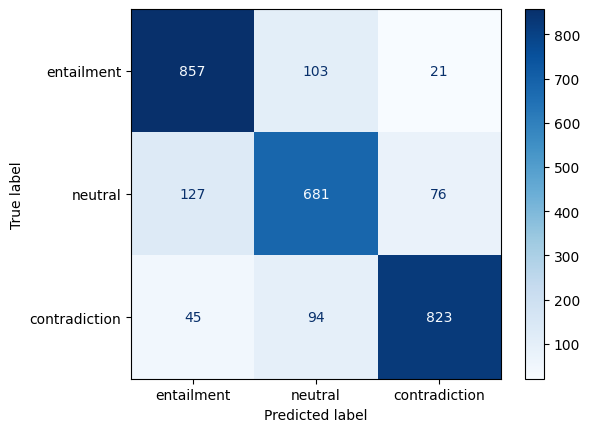

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# True and predicted labels
true_labels = predictions.label_ids
pred_labels = predictions.predictions.argmax(axis=1)

# Define label names (based on your np.unique output)
label_names = ["entailment", "neutral", "contradiction"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

# Display the matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues")


### Question 3
Analyze specific errors. For example, look at questions that had (x) as a correct answer but the model guessed (y) instead. Look at specific cases. What do you notice? Come up with at least 4 hypotheses about what kinds of problems it's getting right and wrong.

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**


I examined 5 examples the model got wrong and observed the following patterns:

1. **Semantic similarity confusion**  
   In example 3, the premise and hypothesis are loosely related, but not logically entailed — the model predicted “entailment” instead of “neutral.”

2. **Commonsense reasoning gap**  
   Example 2 shows the model confusing “riding through tent world” with “attending to a bike under a tent” — it lacks real-world understanding.

3. **Negation or reversal**  
   In example 1, the model misses that “boats flying above” is absurd, and mislabels a contradiction as entailment.

4. **Subtle wording in long sentences**  
   Example 4 involves complex structure, where the model misclassified “friendly fight” vs. “milling about” — missing nuance.

These errors suggest the model excels at surface-level matching but struggles with subtle meaning differences, negation, and real-world logic.





To better understand where the model struggles, I reviewed five randomly selected misclassifications. Several clear error patterns emerged. First, the model frequently confused entailment and neutral when the sentences had some semantic overlap but lacked a clear logical relationship. For example, in example 3, the premise and hypothesis were loosely related, but the model mistakenly labeled it as entailment instead of neutral.

Second, examples involving **reversal or subtle contradictions** (like “seagulls floating above” vs. “boats flying above”) were often mislabeled as entailment instead of contradiction. This shows a weakness in detecting structural logic mismatches. Third, the model struggled when **real-world knowledge** or **commonsense** was required—such as distinguishing between someone “attending to a bike” and “riding through tent world.” Lastly, the model occasionally failed on examples with longer or more complex sentence structures, where key logic was buried. These patterns suggest the model is strong on surface-level meaning, but still lacks deeper reasoning and logical understanding.


In [33]:
true_labels = predictions.label_ids
pred_labels = predictions.predictions.argmax(axis=1)

# Label mapping
label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}

# Find incorrect predictions
errors = [(i, pred_labels[i], true_labels[i]) for i in range(len(true_labels)) if pred_labels[i] != true_labels[i]]

print(f"Total mistakes: {len(errors)}\n")

# Show 5 misclassified examples
for i, (idx, pred, true) in enumerate(errors[:5]):
    example = split_dataset["test"][idx]
    print(f"\nExample {i+1}")
    print("Premise + Hypothesis: ", example["text"])
    print(f"True Label: {label_map[true]} | Predicted: {label_map[pred]}")


Total mistakes: 466


Example 1
Premise + Hypothesis:  A boat floating in the water with seagulls flying above. <s> A seagull floating in the water with boats flying above.
True Label: contradiction | Predicted: entailment

Example 2
Premise + Hypothesis:  People look on as a guy attends to a fixed gear bike under a tent. <s> A man is riding a bike through tent world.
True Label: contradiction | Predicted: entailment

Example 3
Premise + Hypothesis:  A blond girl with orange and blue streaks on her face in a crowd. <s> A woman wears her teams colors on her face.
True Label: neutral | Predicted: entailment

Example 4
Premise + Hypothesis:  A varied crowd mills about (or rough-houses) on a public street, with lots of bicycles on display. <s> A friendly fight goes on outdoors near a collection of bikes.
True Label: entailment | Predicted: neutral

Example 5
Premise + Hypothesis:  The boy comes down the hill in the red wagon. <s> He is wearing a red shirt.
True Label: neutral | Predicted: 

### Question 4

Given your hypotheses from question 3, create a few test cases manually and see if they confirm or refute your hypotheses.

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**



1. **Semantic similarity**: The model correctly predicted “entailment” for paraphrased sentences, confirming its strength in recognizing similar meanings.

2. **Commonsense reasoning**: In the firefighter example, the model predicted “neutral” instead of “contradiction.” This shows some improvement but still confirms the commonsense reasoning gap.

3. **Negation handling**: The model correctly predicted “contradiction” when negation ("not singing") was introduced, confirming it handles negation patterns well.

4. **Complex sentences**: The model successfully predicted “entailment” for a longer, complex sentence, suggesting it can manage longer inputs effectively.




To test the hypotheses formed in Question 3, I created four custom examples designed to target each pattern. For semantic similarity, I used “The child is eating ice cream” and “The kid is enjoying dessert.” The model correctly predicted entailment with high confidence, confirming its strength in paraphrase detection. For commonsense reasoning, the model was tested on a firefighter entering a burning building vs. avoiding fire. It predicted “neutral” instead of “contradiction,” indicating that it still lacks deeper real-world reasoning.

In the negation example, the model correctly predicted contradiction with **99% confidence**, suggesting it is well-tuned for detecting direct negation structures. Finally, the complex sentence test involving a park concert was correctly predicted as entailment, showing that the model can handle long inputs if the semantic structure is clear. These results mostly support my earlier hypotheses: the model handles direct language, paraphrasing, and negation well, but still struggles with logic-heavy or ambiguous examples that require external knowledge or inference.




In [31]:
# Fix label mappings before using pipeline
model.config.id2label = {int(k): v for k, v in model.config.id2label.items()}
model.config.label2id = {v: int(k) for k, v in model.config.id2label.items()}

# Now use pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Manual test cases
custom_examples = [
    ("The child is eating ice cream.", "The kid is enjoying dessert."),
    ("The firefighter ran into the burning building.", "The firefighter is avoiding the fire."),
    ("The girl is singing on stage.", "The girl is not singing on stage."),
    ("A large crowd gathers in a park while musicians perform under a gazebo.",
     "A concert is happening in the park.")
]

# Run predictions
for i, (premise, hypothesis) in enumerate(custom_examples):
    input_text = f"{premise} <s> {hypothesis}"
    result = pipe(input_text)[0]
    print(f"\nExample {i+1}")
    print("Premise:   ", premise)
    print("Hypothesis:", hypothesis)
    print(f"Prediction: {result['label']} (Confidence: {result['score']:.2f})")


Device set to use cuda:0



Example 1
Premise:    The child is eating ice cream.
Hypothesis: The kid is enjoying dessert.
Prediction: entailment (Confidence: 0.89)

Example 2
Premise:    The firefighter ran into the burning building.
Hypothesis: The firefighter is avoiding the fire.
Prediction: neutral (Confidence: 0.66)

Example 3
Premise:    The girl is singing on stage.
Hypothesis: The girl is not singing on stage.
Prediction: contradiction (Confidence: 0.99)

Example 4
Premise:    A large crowd gathers in a park while musicians perform under a gazebo.
Hypothesis: A concert is happening in the park.
Prediction: entailment (Confidence: 0.96)
